# Example: Treasury Bill Pricing, Interest Rate Risk, and Term to Maturity
Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values:

* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816https://www.jstor.org/stable/1880816)

In this example, you will develop a simulation test of the second of the five theorems:

> __Theorem 2__: For a given change in yield from the nominal yield, changes in bond prices are greater the longer the term to maturity

## Learning objectives
This example familiarizes students with computing the sensitivity of the price of United States Treasury Bills, or `T-bills,` to changes in the interest rate (yield, discount rate, etc) as a function of the instruments' duration.

* __Prerequisite__: Before we begin any calculations, we'll load a United States Treasury action dataset for `T-bills` downloaded from [TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/).
* __Objective 1__: First, you'll compute the price of a random `T-bill` and validate your simulated price using Treasury auction data from `2022` and `2023`.
   * `TODO`: Verify the computed price of a random `T-bill` versus the observed auction price using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [isapprox(...)](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) function.
* __Objective 2__: Next, you'll compute the sensitivity of short- and long-duration `T-bill` prices to changes in the interest rate. Long-duration `T-bills` should be more sensitive to interest rate changes than shorter-duration instruments.
    * `TODO` Build a short-duration bill model
    * `TODO` Build a long-duration bill model
    * `TODO`: Specify a range of perturbation values for the effective interest rate $\bar{r}$, and compute this array $\beta$
    * `TODO`: Compute the change of the short and long-duration prices as a function of the yield and visualize the percentage change in the price versus the perturbation $\beta$
* `Discussion question`: Why would you expect __Theorem 2__ to be true (without doing any simulation?)

Let's go!
___

## Setup
We load the [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) package, and several other external [Julia](https://julialang.org/downloads/https://julialang.org/downloads/) packages, as well as some helper code included in the `src` directory, by calling the [include(...)](https://docs.julialang.org/en/v1/manual/code-loading/https://docs.julialang.org/en/v1/manual/code-loading/) command on the file `Include.jl`.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `C:\Users\User\.julia\registries\General.toml`
   Resolving package versions...
   Installed MLDataDevices ── v1.11.2
   Installed EnzymeCore ───── v0.8.13
   Installed ArrayInterface ─ v7.20.0
   Installed JuMP ─────────── v1.29.0
    Updating `C:\Users\User\Documents\GitHub\CHEME-5660-CourseRepository-Fall-2025\lectures\week-2\L2b\Project.toml`
  [336ed68f] + CSV v0.10.15
  [5ae59095] + Colors v0.13.1
  [a93c6f00] + DataFrames v1.7.1
⌅ [864edb3b] + DataStructures v0.18.22
  [31c24e10] + Distributions v0.25.120
  [5789e2e9] + FileIO v1.17.0
  [587475ba] + Flux v0.16.5
⌃ [033835bb] + JLD2 v0.5.15
  [2fda8390] + LsqFit v0.15.1
  [b8f27783] + MathOptInterface v1.43.0
  [0b1bfda6] + OneHotArrays v0.2.10
  [91a5bcdd] + Plots v1.40.19
⌅ [08abe8d2] + PrettyTables v2.4.0
  [10745b16] + Statistics v1.11.1
  [2913bbd2] + StatsBase v0.34.6
  [f3b207a7] + StatsPlots v0.15.7
  [4119e0b

##  Prerequisite: Load the Treasury Auction Dataset
We'll explore `T-bill` prices from United States Treasury auctions between April 2023 and January 2024 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). We load the `CSV` dataset using the `MyTreasuryBillDataSet()` function, which returns the auction data [as a `DataFrame`](https://dataframes.juliadata.org/stable/):

In [2]:
dataset = MyTreasuryBillDataSet()

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
1,912797GV3,Bill,4-Week,08/31/2023,09/05/2023,10/03/2023,99.5893,0.0539
2,912797HD2,Bill,8-Week,08/31/2023,09/05/2023,10/31/2023,99.1771,0.05423
3,912797HX8,Bill,17-Week,08/30/2023,09/05/2023,01/02/2024,98.2381,0.05516
4,912797FA0,Bill,42-Day,08/29/2023,08/31/2023,10/12/2023,99.3828,0.05412
5,912796ZD4,Bill,13-Week,08/28/2023,08/31/2023,11/30/2023,98.6502,0.05503
6,912797GP6,Bill,26-Week,08/28/2023,08/31/2023,02/29/2024,97.2953,0.0559
7,912797GU5,Bill,4-Week,08/24/2023,08/29/2023,09/26/2023,99.5889,0.05395
8,912797HC4,Bill,8-Week,08/24/2023,08/29/2023,10/24/2023,99.1771,0.05423
9,912797HW0,Bill,17-Week,08/23/2023,08/29/2023,12/26/2023,98.2431,0.055


Next, let's set the dimension of our auction dataset in the `number_of_bills` variable:

In [3]:
number_of_bills = nrow(dataset);

## Objective 1: Compute and Verify the Price of a Random Treasury Bill
Before we do any sensitivity calculations, let's double-check our Treasury pricing implementation.
We begin computing the price of a random T-bill selected from the `dataset` by building a discounting model, in this case, a discrete compounding model. Let's construct [an instance of the `DiscreteCompoundingModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.DiscreteCompoundingModel) and store this discount model in the `discount_model` variable.

In [4]:
discount_model = DiscreteCompoundingModel();

Next, select a bill from the `dataset` by randomly selecting an index from `1...number_of_bills` using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/#Base.rand):

In [5]:
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 45


In [6]:
dataset[random_bill_index,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
45,912797GG6,Bill,4-Week,07/13/2023,07/18/2023,08/15/2023,99.5948,0.05318


### Check: Verify the computed price of a random T-bill
Create an instance of [the `MyUSTreasuryZeroCouponBondModel` model](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}), assuming a par value of `100 USD` and two compounding periods per year. Update the duration `T` and `rate` fields from random Bill data, and use the short-cut syntax to compute the price. Save the updated model in the `zero_coupon_model` variable. 

In [7]:
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
        
    ### BEGIN SOLUTION    
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
    ### END SOLUTION    
        
)) |> discount_model;

In [8]:
zero_coupon_model.price

99.59818279920309

__Check__: If the computed and observed price are different, i.e., they have relative difference tolerance of `rtol`$>$`1e-4`, then the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) will `fail`, resulting in an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError):

In [9]:
@assert isapprox(zero_coupon_model.price, dataset[random_bill_index,:Price], rtol=1e-4)

## Objective 2: Compute the sensitivity of the T-bill price to interest rate and term to maturity

Let's test Theorem 2 by simulating prices as a function of interest rate and term to maturity. 
* Create models for two bills $i$ and $j$ from the `dataset`. Bills $i$ and $j$ should have a significant difference in duration, for example, `4 weeks` versus `52 weeks`
* Then simulate how these instruments' prices change as we vary the yield by the same percentage. Assume a $V_{P} = 100$ USD for both instruments and semiannual compounding, i.e., $n = 2$.

### TODO: Build a short-duration bill model
Select the index of a random `4-Week` duration treasury bill, and save this index in the variable `i`, and then build [a `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryCouponSecurityModel},%20NamedTuple}).
* We can select data from `dataset` using [the `filter(...)` method exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter). The [`filter(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) takes a function `func` as its first argument and a data frame `df` as its second argument. It returns a data frame containing only the rows from df for which `func` returns `true.`

In [10]:
short_duruation_dataset = filter(Symbol("Security Term") => x-> x == "4-Week", dataset)
i = nrow(short_duruation_dataset) |> x-> rand(1:x);
short_duruation_dataset[i,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
4,912797GS0,Bill,4-Week,08/10/2023,08/15/2023,09/12/2023,99.5893,0.0539


Build [an `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) to model the randomly selected  `4-Week` treasury bill, save this model in the `short_duration_model` variable, and then compute the price using the short-cut syntax:

In [11]:
short_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    
    ### BEGIN SOLUTION    
    par = 100, n = 2, 
    T = short_duruation_dataset[i, Symbol("Security Term")] |> String |> securityterm,
    rate = short_duruation_dataset[i, Symbol("Investment Rate")],
    ### END SOLUTION
        
)) |> discount_model; # short cut price calculation

#### Check: Is the short-duration price `similar` to the dataset?

In [12]:
short_duration_price = short_duration_model.price
@assert isapprox(short_duration_price, short_duruation_dataset[i,:Price], rtol = 1e-3)

### TODO: Build a long-duration bill model

Select the index of a random `52-Week` duration treasury bill, save this index as the variable `j`:

In [13]:
long_duruation_dataset = filter(Symbol("Security Term") => x-> x == "52-Week", dataset)
j = nrow(long_duruation_dataset) |> x-> rand(1:x);
long_duruation_dataset[j,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
1,912797GK7,Bill,52-Week,08/08/2023,08/10/2023,08/08/2024,94.8838,0.05351


Next, build [a `MyUSTreasuryZeroCouponBondModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) to model the random `52-Week` treasury bill and compute the price using the short-cut syntax:

In [14]:
long_duration_model = build(MyUSTreasuryZeroCouponBondModel, (
    
    ### BEGIN SOLUTION   
    par = 100, n = 2, 
    T = long_duruation_dataset[j, Symbol("Security Term")] |> String |> securityterm,
    rate = long_duruation_dataset[j, Symbol("Investment Rate")],
    ### END SOLUTION
        
)) |> discount_model;

#### Check: Is the long-duration price `similar` to the dataset?

In [15]:
long_duration_price = long_duration_model.price
@assert isapprox(long_duration_price, long_duruation_dataset[j,:Price], rtol = 1e-3)

### TODO: Specify a range of perturbation values
To simulate the impact of changes in the interest rate, let's perturb the effective nominal interest rate $\bar{r}$, with all other values held constant, i.e., generate a new rate of the form $\bar{r}\leftarrow\beta\cdot\bar{r}$, where $\beta$ is a perturbation value; if $\beta<1$ the perturbed interest rate is _less than_ the nominal rate, if $\beta=1$ the perturbed interest rate is _equals_ the nominal rate, and if $\beta>1$ the perturbed interest rate is _greater than_ the nominal rate.

* First, we specify the number of perturbation values we want to consider; we store this value in the `number_of_samples` variable. Note: if `number_of_samples` is odd, the perturbation range will include the nominal interest rate as the center value.
* Next, we specify the lower and upper values of the perturbation range; the lower bound is stored in the `β₁` variable, while the upper bound is stored in the `β₂` variable.
* Finally, we compute the perturbation array (stored in the `β`-variable) using the [range function](https://docs.julialang.org/en/v1/base/math/#Base.range) in combination with the [Julia pipe |> operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping), and the [collect function](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}), which converts a range type to a collection, i.e., an array

In [16]:
### BEGIN SOLUTION
number_of_samples = 11;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;
### END SOLUTION

### TODO: Compute the change of the short and long-duration prices as a function of the yield 
Compute the price of the short and long-duration notes or bonds using different values for the yield (stored in the `rate` field), and store the results in the `theorem_2_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective rate value for each model $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `short_duration_model` and the `long_duration_model` models instances with the new rates (set the `rate` field), and compute the new prices
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price for each instrument in column 2 (short) and column 3 (long) of the `theorem_2_simulation_array`

In [17]:
theorem_2_simulation_array = Array{Float64,2}(undef, number_of_samples, 3);
for i ∈ eachindex(β)
    
    β_value = β[i];
    
    ### BEGIN SOLUTION
    short_duration_model.rate = β_value*(short_duruation_dataset[i, Symbol("Investment Rate")]);
    long_duration_model.rate = β_value*(long_duruation_dataset[j, Symbol("Investment Rate")]);
    new_short_duration_price = short_duration_model |> discount_model |> x-> x.price
    new_long_duration_price = long_duration_model |> discount_model |> x-> x.price
    
    theorem_2_simulation_array[i,1] = β_value
    theorem_2_simulation_array[i,2] = ((new_short_duration_price - short_duration_price)/short_duration_price)*100
    theorem_2_simulation_array[i,3] = ((new_long_duration_price - long_duration_price)/long_duration_price)*100
    ### END SOLUTION
end

#### Visualize
`Unhide` the code block below to see how we plotted the short- and long-duration T-bills response to changes in the interest (discount) rate $\bar{r}$.
* __Summary__: The longer maturity T-bill is more sensitive to changes in the interest rate (light-gray line) than the shorter duration instrument (black line). Thus, our simulations support Theorem 4.

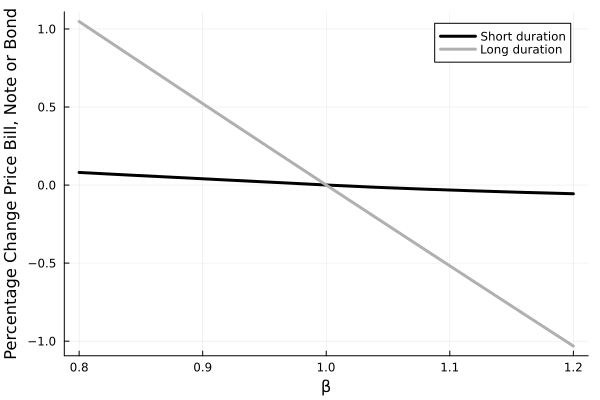

In [18]:
let
    plot(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,2], label="Short duration", lw=3, c=:black, 
            xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")
    plot!(theorem_2_simulation_array[:,1], theorem_2_simulation_array[:,3], label="Long duration", lw=3, c=:gray69, 
            xlabel="β", ylabel="Percentage Change Price Bill, Note or Bond")
end

## Discussion: Does your simulation result make sense?
If your simulation was implemented correctly, the longer duration T-bill was more sensitive to changes in the nominal effective interest rate $\bar{r}$. 
1. Compare the percentage change in the price of the short- and long-duration T-bills at $\beta = 0.9$; the longer-duration instrument should have a larger percentage change in price. Similarly, for $\beta = 1.1$, the cost of the longer-duration instrument should show a bigger change relative to the short-duration T-bill.
2. Intuitively, why might you expect __Theorem 2__ to be true?
3. Who is more at risk in a variable interest rate environment, a short-term or long-term bondholder?

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.